# Polars vs Pandas

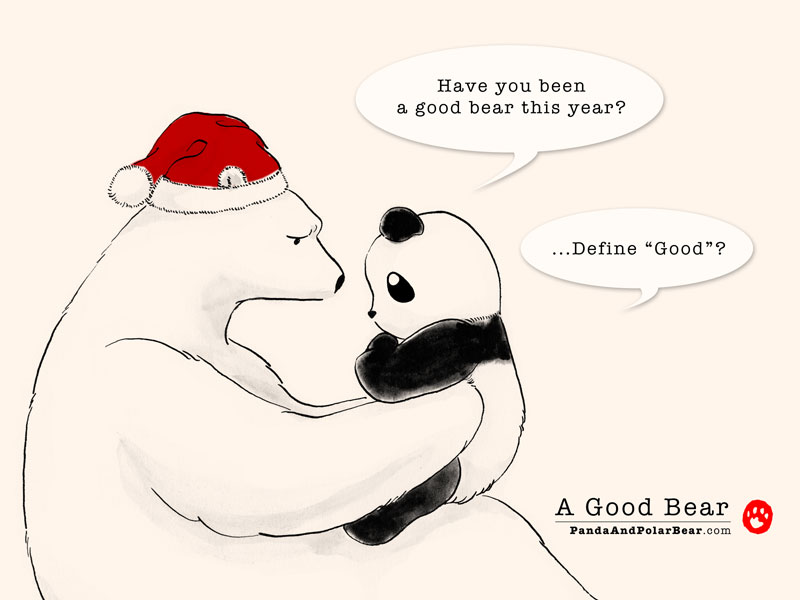

(Didn't know this was a thing before I googled "Panda vs Polar" accidently, Credits: [Panda & Polar Bear](https://www.pandaandpolarbear.com/))

## Polars

* [Python Docs](https://pola-rs.github.io/polars-book/user-guide/introduction.html)
* [Github](https://github.com/pola-rs/polars)
* [PyPI](https://pypi.org/project/polars/)
* Features:
    * Lazy & eager computation
    * Rust implementation
    * [Arrow](https://arrow.apache.org/) memory layout
    * Easy and transparent parallelisation using multithreading
    * PySpark-like syntax and thus heavily inspired by SQL
    * Supports real NA values in contrast to Pandas
    * Easily deal with complex data types, e.g. list of strings/floats
    * Copy-On-Write (COW) semantics in contrast to Pandas where you kind of never know

# Pandas

* [Docs](https://pandas.pydata.org/)
* [Github](https://github.com/pandas-dev/pandas)
* [PyPI](https://pypi.org/project/pandas/)
* Features:
    * De facto standard data wrangling library for Python
    * Multi-index for rows and columns
    * Quite unrestricted in what's possible, e.g. everything hashable can be a column name like integers, floats, enums
    * Tons of functionality
    * No parallelization
    * Built on top of Numpy
    

# Other Contenders

* [Vaex](https://github.com/vaexio/vaex): Lazy Out-of-Core dataframes
* [Dask](https://docs.dask.org/): Built on top of Pandas and parallelizes it, on a single node or distributed.
* [H2O Datatable](https://github.com/h2oai/datatable): Inspired by R's data.tables
* [Modin](https://modin.readthedocs.io/en/latest/): Uses [Ray](https://docs.ray.io/) or [Dask](https://docs.dask.org/) to parallelize Pandas
* [RAPIDS](https://rapids.ai/): Data analysis on GPU

Performance [benchmark](https://h2oai.github.io/db-benchmark/) of various frameworks

# Prelude

In [1]:
from datetime import datetime

import numpy as np
import polars as pl
from pathlib import Path
from polars import col, lit
import pandas as pd
from pandas.io.common import get_handle

In [2]:
pl.__version__

'0.7.18'

In [3]:
pd.__version__

'1.2.4'

In [4]:
# Download a huge csv as a test. Takes a while and only needed once...
big_csv = Path("./big.csv")
csv_url = "http://sdm.lbl.gov/fastbit/data/star2002-full.csv.gz"

if not big_csv.exists():
    with get_handle(csv_url, compression="gzip", mode="r") as fh_in, open(big_csv, "bw") as fh_out:
        fh_out.write(fh_in.handle.buffer.read())

## Eager Execution

In [5]:
edf = pl.read_csv(str(big_csv), has_headers=False)

In [6]:
edf.filter(col("column_1") == 1).select(["column_9"]).head()

column_9
i64
654
61
7
27
1


#### alternatively *Pandas* style (not recommended!)

In [7]:
edf[edf["column_1"] == 1][["column_9"]].head()

column_9
i64
654
61
7
27
1


Why shouldn't I use the Pandas style? Because ...

* it's much harder to read since it's not *operator chaining*,
* it's more verbose if you assign actual variable names to your dataframes and not just use `df` all the time. Check out this filtering example: `agg_metric_df[agg_metric_df["metric_1"] < 0.9]`. Using `col` to refer to the column of the current dataframe is much cleaner,
* it's not possible to switch later from eager to lazy execution

## Lazy Execution

Just switching `read_csv` to `scan_csv` is all it needs to go from eager to lazy in this example. `collect` or `fetch` is then used to trigger the execution.

In [8]:
ldf = pl.scan_csv(str(big_csv), has_headers=False)

In [9]:
ldf = ldf.filter(col("column_1") == 1)
ldf.select(["column_9"]).collect().head()

column_9
i64
654
61
7
27
1


Pandas style fails in lazy mode:

In [10]:
ldf = pl.scan_csv(str(big_csv), has_headers=False)
ldf[ldf["column_1"] == 1][["column_9"]].head()

TypeError: 'LazyFrame' object is not subscriptable

## Slicing & Indexing

Slicing and indexing in Polars works with the help of the subscript syntax similar to Numpy, i.e. df[1] or df[1, 2]. Some simple rules apply:

* indexing by a single dimension 
   * returns one or several rows if indexed by an integer, e.g. `df[42]`, `df[42:]`,
   * returns one or several columns if index by a string, e.g. , `df["my_col"]`, `df[["col1", "col2]]`, 
   
* indexing by two dimensions  
   * returns the row(s) indexed by an integer in the first dimension and the column(s) indexed by integer or string in the second dimension, e.g. `df[69, 42]` or `df[69, "col_42"]`
   
In case of integers also slices, e.g. `1:`, are possible.

In [11]:
edf[1] # this is a bug right now

Series: 'column_2' [i64]
[
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
]

In [12]:
edf[[1]]

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64
1,1613423,808,2.0011015223e7,1613424,886,0,0,61,371,2.0011204115e7,23.326,2288071,-2.47e-1,0.456,57.811


In [13]:
edf[1, 3] # index by (row, column)

20011015.222604

In [14]:
edf[1, "column_4"] # or as string

20011015.222604

In [15]:
edf[1, [2, 3]]  # index by (row, column) but returns data frame

column_3,column_4
i64,f64
808,2.0011015223e7


In [16]:
edf[1:4, "column_4":] # slice by row and column's name

column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64
2.0011015223e7,1613424,886,0,0,61,371,2.0011204115e7,23.326,2288071,-2.47e-1,0.456,57.811
2.0011015223e7,1613424,638,0,0,7,121,2.0011204115e7,2.444,2288071,-3.91e-1,0.59,167.757
2.0011015223e7,1613424,4259,0,0,1024,1302,2.0011204115e7,9.522,2288071,-2.9e-1,0.446,8.644


Since in Pandas there is an explicit index that can be any type, not just integer and columns that can have any immutable datatype, it has to workaround several ambiguities with special accessors like `iloc`, `loc`, `at`, `iat`, etc.

In [17]:
pdf = edf.to_pandas()

In [18]:
pdf.iloc[1, 3]

20011015.222604

In [19]:
# when mixing indexing by integer and by string it gets less comprehensible in Pandas
pdf["column_4"].iloc[1] 

20011015.222604

In [20]:
pdf.iloc[1, [2, 3]]

column_3    8.080000e+02
column_4    2.001102e+07
Name: 1, dtype: float64

In [21]:
pdf[["column_4"]].iloc[1:4]

,column_4
1,2.001102e+07
2,2.001102e+07
3,2.001102e+07


In [22]:
# for slicing with column names and guaranteed indexing by integer we have to write:
pdf.loc[:, "column_4":].iloc[1:4]
# `pdf.loc[1:4, "column_4":]` works only as long the index is set correctly.

,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
1,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140
3,2.001102e+07,1613424,4259,0,0,1024,1302,2.001120e+07,9.521868,2288071,-0.290154,0.446027,8.644362


## Dealing with missing values

In [23]:
left_df = pl.DataFrame({"a": [1, 2, 3], "b": [None, "b", "c"]})
right_df = pl.DataFrame({"a": [1, 2], "c": [42, 69]})

df = left_df.join(right_df, on="a", how="left")
df

a,b,c
i64,str,i64
1,null,42
2,"""b""",69
3,"""c""",null


Note that the last element of the `c` column is `null`, not `NaN` as in Pandas, and the datatype is still int and not automatically converted to float as in Pandas.

In [24]:
df.filter(col("c").is_null())

a,b,c
i64,str,i64
3,"""c""",null


Pandas does something pretty scary here

In [25]:
left_pdf = left_df.to_pandas()
right_pdf = right_df.to_pandas()

Note that "c"-column has type int:

In [26]:
right_pdf.dtypes

a    int64
c    int64
dtype: object

In [27]:
pdf = pd.merge(left_pdf, right_pdf, on="a", how="left")

In [28]:
pdf

,a,b,c
0,1,None,42.0
1,2,b,69.0
2,3,c,NaN


Depending on the datatype, Pandas shows `None` or `NaN`, also note that the column `c` was converted from `int` to `float` without our consent!

# New columns

In [29]:
df.with_column((lit(3)*col("c")).alias("3*c"))

a,b,c,3*c
i64,str,i64,i64
1,null,42,126
2,"""b""",69,207
3,"""c""",null,null


Same is possible in Pandas but note that we have to retype again the variable name `pdf` just to access a column!

In [30]:
pdf.assign(**{"3*c": 3*pdf["c"]})

,a,b,c,3*c
0,1,None,42.0,126.0
1,2,b,69.0,207.0
2,3,c,NaN,NaN


# Column Expressions

In [31]:
df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", None],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "C", "B"],
    }
)
df

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",0.27,"""A"""
2,"""ham""",0.521,"""A"""
3,"""spam""",0.825,"""B"""
null,"""egg""",0.621,"""C"""
5,null,0.891,"""B"""


In [32]:
# and in Pandas
pdf = df.to_pandas()

#### Construct a new dataframe with a sorted column and some aggregations

In [33]:
df.select(
    [
        pl.sum("nrs"), # or equivalently col("nrs").sum()
        col("names").sort(),
        col("names").n_unique().alias("unique_names_1"),
    ]
)

nrs,names,unique_names_1
i64,str,u32
11,null,5
11,"""egg""",5
11,"""foo""",5
11,"""ham""",5
11,"""spam""",5


In Pandas we create a new DataFrame and reference several times `pdf`

In [34]:
pd.DataFrame(
    {
        "nrs": pdf["nrs"].sum(),
        "names": pdf["names"].sort_values(),
        "unique_names_1": pdf["names"].nunique(dropna=False),
    }
)

,nrs,names,unique_names_1
3,11.0,egg,5
0,11.0,foo,5
1,11.0,ham,5
2,11.0,spam,5
4,11.0,None,5


#### Select certain elements from a column by filtering from another

In [35]:
df.select(col("names").filter(col("random") > 0.4))

names
str
"""ham"""
"""spam"""
"""egg"""
null


Syntax in Pandas is way less readable

In [36]:
pdf.loc[pdf["random"] > 0.4][["names"]]

,names
1,ham
2,spam
3,egg
4,None


Another way in Pandas is to use the query style:

In [37]:
pdf.query("random > 0.4")[["names"]]

,names
1,ham
2,spam
3,egg
4,None


The problem with Pandas' query style is that it is basically string hacking with no checks whatsoever until the code is executed. Also reuse of certain expressions is highly limited if you have just strings.

### Complex expressions are also possible

All expressions in Polars are *embarassingly parallel* by design and thus automatically parallelized

In [38]:
df.select(
    [
        (pl.sum("nrs") * pl.when(col("random") > 0.5)
                           .then(0)
                           .otherwise(col("random"))
        ).alias("result")
    ]
)

result
f64
2.973
0.0
0.0
0.0
0.0


SQL-like `when`/`then`/`otherwise` statements are not possible in Pandas, thus we have to use `np.where`:

In [39]:
pd.Series(
    np.where(pdf["random"] > 0.5, 0, pdf["random"] * pdf["nrs"].sum()), name="result"
).to_frame()

,result
0,2.973213
1,0.000000
2,0.000000
3,0.000000
4,0.000000


In [40]:
# or easier to read but much slower since not vectorized at all
pdf.random.apply(lambda x: 0 if x > 0.5 else x * pdf["nrs"].sum()).to_frame()

,random
0,2.973213
1,0.000000
2,0.000000
3,0.000000
4,0.000000


#### Even window expressions are possible

In [41]:
df.select(
    [
        col("*"),  # select all
        col("random").sum().over("groups").alias("sum[random]/groups"),
        col("random").list().over("names").alias("random/name"),
    ]
)

nrs,names,random,groups,sum[random]/groups,random/name
i64,str,f64,str,f64,list
1,"""foo""",0.27,"""A""",0.791,"""[0.2702920925095984]"""
2,"""ham""",0.521,"""A""",0.791,"""[0.5210243165448514]"""
3,"""spam""",0.825,"""B""",1.716,"""[0.8248294839356618]"""
null,"""egg""",0.621,"""C""",0.621,"""[0.6213192138749672]"""
5,null,0.891,"""B""",1.716,"""[0.8909539423562371]"""


Doing the same in Pandas is a bit more complex. Also note that there is an unexpected `NaN` in the last row. This is due to the fact that when inserting `pdf.groupby(['names'], dropna=False)['random'].apply(list)` we compare `NaN` to `NaN` which is false by definition. This is just another subtle problem caused by the fact that Pandas uses `NaN` to express `NA`.
Also note that Polars needs no explicit index like Pandas to do operations like this, just like Spark has no way to set an index explicitely.

In [42]:
(pdf.set_index("groups")
    .assign(**{"sum[random]/groups": pdf.groupby(['groups'])['random'].sum()})
    .set_index("names")
    .assign(**{"random/name": pdf.groupby(['names'], dropna=False)['random'].apply(list)})
    .reset_index()
)

,names,nrs,random,sum[random]/groups,random/name
0,foo,1.0,0.270292,0.791316,[0.2702920925095984]
1,ham,2.0,0.521024,0.791316,[0.5210243165448514]
2,spam,3.0,0.824829,1.715783,[0.8248294839356618]
3,egg,NaN,0.621319,0.621319,[0.6213192138749672]
4,None,5.0,0.890954,1.715783,NaN


In [43]:
# or alternatively using `join` which is also avoiding the NaN problem
pdf.join(
    pdf.groupby('groups').random.sum().rename("sum[random]/groups"), on="groups"
).join(
    pdf.groupby('names', dropna=False).random.apply(list).rename("random/name"), on="names"
)

,nrs,names,random,groups,sum[random]/groups,random/name
0,1.0,foo,0.270292,A,0.791316,[0.2702920925095984]
1,2.0,ham,0.521024,A,0.791316,[0.5210243165448514]
2,3.0,spam,0.824829,B,1.715783,[0.8248294839356618]
3,NaN,egg,0.621319,C,0.621319,[0.6213192138749672]
4,5.0,None,0.890954,B,1.715783,[0.8909539423562371]


# GroupBy

In [44]:
df = pl.read_csv("https://theunitedstates.io/congress-legislators/legislators-current.csv")
pdf = df.to_pandas()

In [45]:
(df.lazy()  # allows for working only on a subset using limit
   .groupby("first_name")
   .agg(
       [
           col("party").count().alias("n_party"),  # renaming an aggregated column is a bliss
           col("gender").list(),
           col("last_name").first(),
       ]
   )
   .sort("n_party", reverse=True)
   .limit(5)
   .collect()
)

first_name,n_party,gender_agg_list,last_name_first
str,u32,list,str
"""John""",19,"""[M, M, ... M]""","""Barrasso"""
"""Mike""",12,"""[M, M, ... M]""","""Kelly"""
"""Michael""",11,"""[M, M, ... M]""","""Bennet"""
"""David""",11,"""[M, M, ... M]""","""Cicilline"""
"""James""",9,"""[M, M, ... M]""","""Inhofe"""


Note how easily we can deal with lists of strings by aggregating over gender using `list()`.

In Pandas the same operation feels more like string hacking and renaming happens as a separate step having unnecessary repetitions of the column names. Everything is of course eagerly evaluated.

In [46]:
(pdf.groupby("first_name")
    .agg({"party": "count", 
          "gender": lambda grp: grp.to_list(), 
          "last_name": "first"})
    .rename(columns={"party": "n_party", 
                     "gender": "gender_agg_list", 
                     "last_name": "last_name_first"})
    .sort_values(by="n_party", ascending=False)
    .reset_index()
    .head(5))

,first_name,n_party,gender_agg_list,last_name_first
0,John,19,"[M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, ...",Barrasso
1,Mike,12,"[M, M, M, M, M, M, M, M, M, M, M, M]",Kelly
2,Michael,11,"[M, M, M, M, M, M, M, M, M, M, M]",Bennet
3,David,11,"[M, M, M, M, M, M, M, M, M, M, M]",Cicilline
4,James,9,"[M, M, M, M, M, M, M, M, M]",Inhofe


#### Conditionals in aggregations

In [47]:
(df.lazy()
   .groupby("state")
   .agg(
       [
           (col("party") == "Democrat").sum().alias("demo"),
           (col("party") == "Republican").sum().alias("rep"),
       ]
   )
   .sort("demo", reverse=True)
   .limit(5)
   .collect()
)

state,demo,rep
str,u32,u32
"""CA""",44,11
"""NY""",21,8
"""IL""",15,5
"""TX""",13,24
"""NJ""",12,2


The translation to Pandas is "somewhat" more complicated... kudos to everyone able to solve this without looking it up on StackOverflow :-) 

In [48]:
(pdf.groupby("state")
    .agg({"party": [("demo", lambda grp: np.sum(grp == "Democrat")), 
                    ("rep", lambda grp:  np.sum(grp == "Republican"))]})
    .droplevel(0, axis=1) 
    .reset_index()
    .sort_values(by="demo", ascending=False)
    .head(5)
)

,state,demo,rep
5,CA,44,11
37,NY,21,8
16,IL,15,5
47,TX,13,24
34,NJ,12,2


#### Composition and reuse of more complex operations

In [49]:
def compute_age() -> pl.Expr:
    # Date64 is time in ms
    ms_to_year = 1e3 * 3600 * 24 * 365
    return (
        lit(datetime(2021, 1, 1)) - col("birthday")
    ) / (ms_to_year)


def avg_age(gender: str) -> pl.Expr:
    return (
        compute_age()
        .filter(col("gender") == gender)
        .mean()
        .alias(f"avg {gender} age")
    )


(df.lazy()
   .groupby(["state"])
   .agg(
       [
            avg_age("M"),
            avg_age("F"),
       ]
   )
   .sort("state")
   .limit(5)
   .collect()
)

state,avg M age,avg F age
str,f64,f64
"""AK""",71.899,63.657
"""AL""",65.167,56.038
"""AR""",58.325,null
"""AS""",null,73.06
"""AZ""",60.004,59.168


Translating this to Pandas is really hard since we have no way to refer to a column. Also with Pandas' `agg` we have only access to the aggregation column and cannot filter by another, thus we have to use `apply`.

In [50]:
def p_compute_age(grp: pd.DataFrame):
    # Date64 is time in ms
    s_to_year = 3600 * 24 * 365
    return (
        (datetime(2021, 1, 1) - grp["birthday"]).dt.total_seconds()
    ) / (s_to_year)


def p_avg_age(grp: pd.DataFrame, gender: str):
    age = p_compute_age(grp)
    mean_age = age[grp["gender"] == gender].mean()
    return pd.Series([mean_age], index=[f"avg {gender} age"])


(pdf.groupby("state")
    .apply(
        lambda grp: pd.concat(
            [p_avg_age(grp, gender="M"),
             p_avg_age(grp, gender="F")]
        )
    )
    .reset_index()
    .sort_values(by="state")
    .head(5)
)

,state,avg M age,avg F age
0,AK,71.898630,63.657534
1,AL,65.167466,56.038356
2,AR,58.324658,NaN
3,AS,NaN,73.060274
4,AZ,60.003767,59.168037


The same code in Pandas just feels not as clean as in Polars, thus showing nicely the power that comes with Polars' composable expressions.

# User-Defined (Aggregation) Functions

In [51]:
df = pl.DataFrame({"foo": np.arange(10), 
                   "bar": np.random.rand(10), 
                   "cls": np.random.randint(2, size=10)})
pdf = df.to_pandas()

In [52]:
df

foo,bar,cls
i64,f64,i64
0,0.232,0
1,0.359,0
2,0.404,1
3,0.855,0
4,0.794,1
5,0.598,1
6,0.747,1
7,0.656,0
8,0.999,0


#### Vector Operations

Use `map` for vector operations on a whole column, i.e. series -> series:

In [53]:
def my_custom_func(s: pl.Series) -> pl.Series:
    return np.exp(s) / np.log(s)

In [54]:
df.filter(col("bar").map(my_custom_func, return_dtype=pl.Float64) > -1)

foo,bar,cls
i64,f64,i64
0,0.232,0


Use `apply` for scalar operations on a cell or group level but returning a scalar:

In [55]:
df.select(col("bar").apply(lambda x: 3*x))

bar
f64
0.696
1.078
1.211
2.566
2.383
1.794
2.24
1.967
2.996


In Pandas, you have `apply` and `applymap` working quite similarily:

In [56]:
pdf[pdf["bar"].apply(my_custom_func) > -1]

,foo,bar,cls
0,0,0.232159,0


In [57]:
pdf[["bar"]].applymap(lambda x: 3*x)

,bar
0,0.696478
1,1.078346
2,1.211216
3,2.566302
4,2.382630
5,1.793900
6,2.239719
7,1.966602
8,2.995891
9,2.307976


#### Aggregation Operations

In [58]:
df.groupby(["cls"]).agg([col("bar").apply(lambda grp: 3*grp.sum())])

cls,
i64,f64
0,9.304
1,9.935


Quite analogous in Pandas but of course you need to fight the multi-index:

In [59]:
pdf.groupby("cls", as_index=False).agg({"bar": lambda grp: 3 * grp.sum()})

,cls,bar
0,0,9.303619
1,1,9.935442
